# Electricity Customer에 대해서 수행

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 모델 구성하기
* 시간단위의 데이터로써 24x30 =720 즉 30일을 바라봄

In [7]:
data = pd.read_csv('./GeneralData/ElectricityCustomer.csv')
sequence_length = 720
pred_len = 1

In [8]:
data = data.drop(columns='Unnamed: 0')

In [9]:
data

,customer1,customer2,customer3,customer4,customer5,customer6,customer7,customer8,customer9,customer10
0,10.152284,96.017070,1.737619,595.528455,302.439024,1104.166667,26.568683,989.898990,204.545455,266.666667
1,11.421320,93.172119,0.000000,583.333333,284.146341,934.523810,23.742227,1000.000000,208.041958,277.419355
2,11.421320,98.150782,0.000000,569.105691,259.756098,851.190476,22.046354,1006.734007,211.538462,249.462366
3,11.421320,87.482219,0.000000,508.130081,258.536585,717.261905,23.742227,831.649832,187.062937,226.881720
4,10.152284,88.904694,0.000000,445.121951,230.487805,625.000000,19.785189,764.309764,167.832168,208.602151
...,...,...,...,...,...,...,...,...,...,...
8756,8.883249,100.995733,6.950478,745.934959,368.292683,1363.095238,45.223290,1262.626263,367.132867,325.806452
8757,10.152284,91.038407,6.950478,648.373984,345.121951,1279.761905,46.353872,1077.441077,305.944056,280.645161
8758,7.614213,88.193457,6.950478,644.308943,347.560976,1258.928571,45.223290,1006.734007,286.713287,289.247312
8759,8.883249,85.348506,6.950478,646.341463,335.365854,1232.142857,42.962125,1003.367003,258.741259,290.322581


<AxesSubplot: >

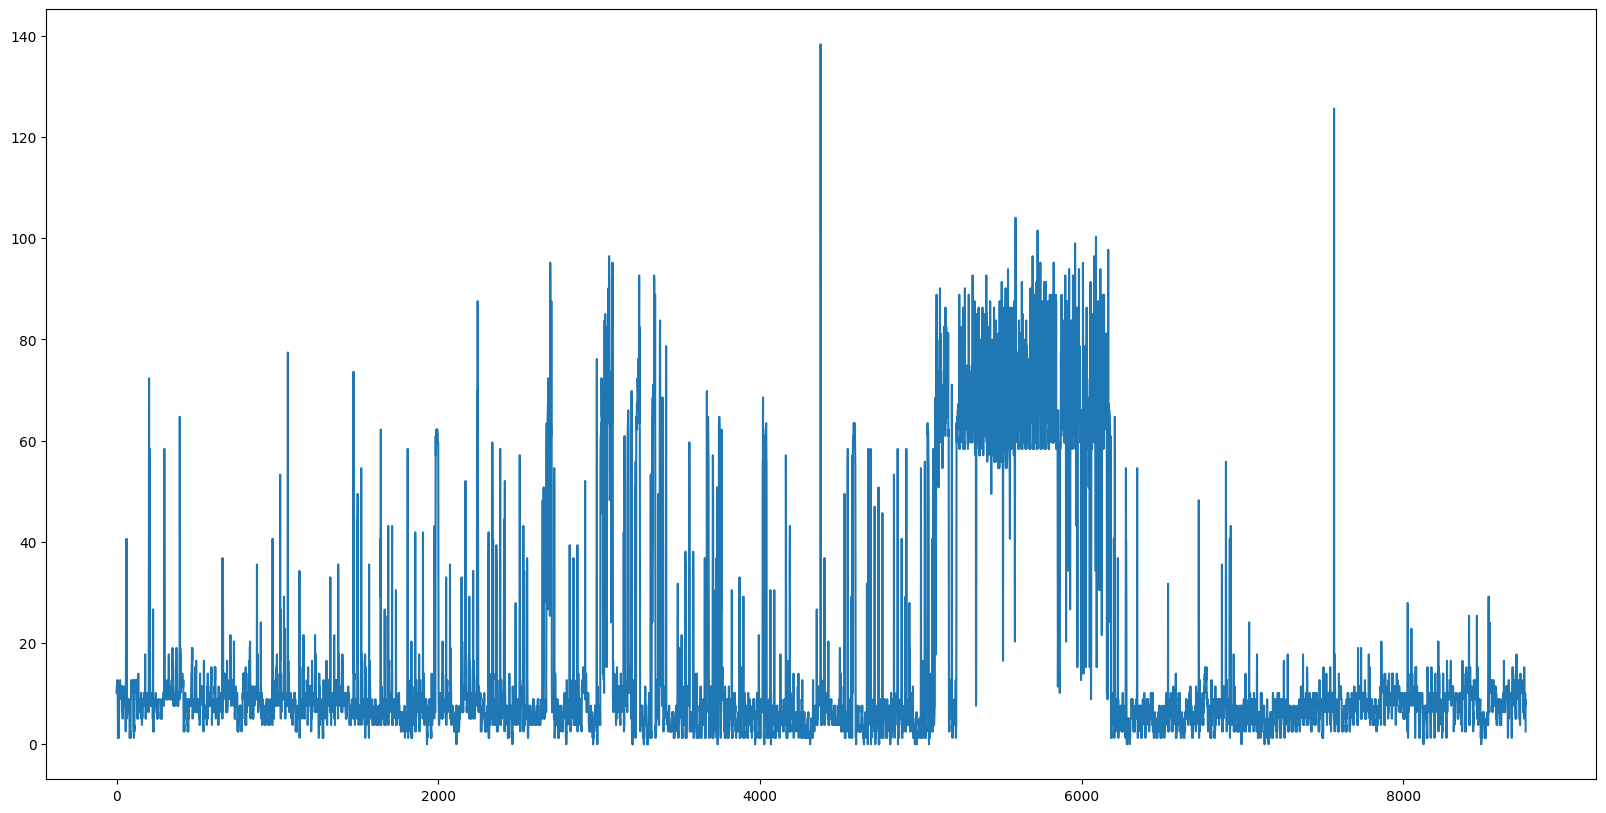

In [19]:
plt.figure(figsize=(20,10))
data['customer1'].plot()

<AxesSubplot: >

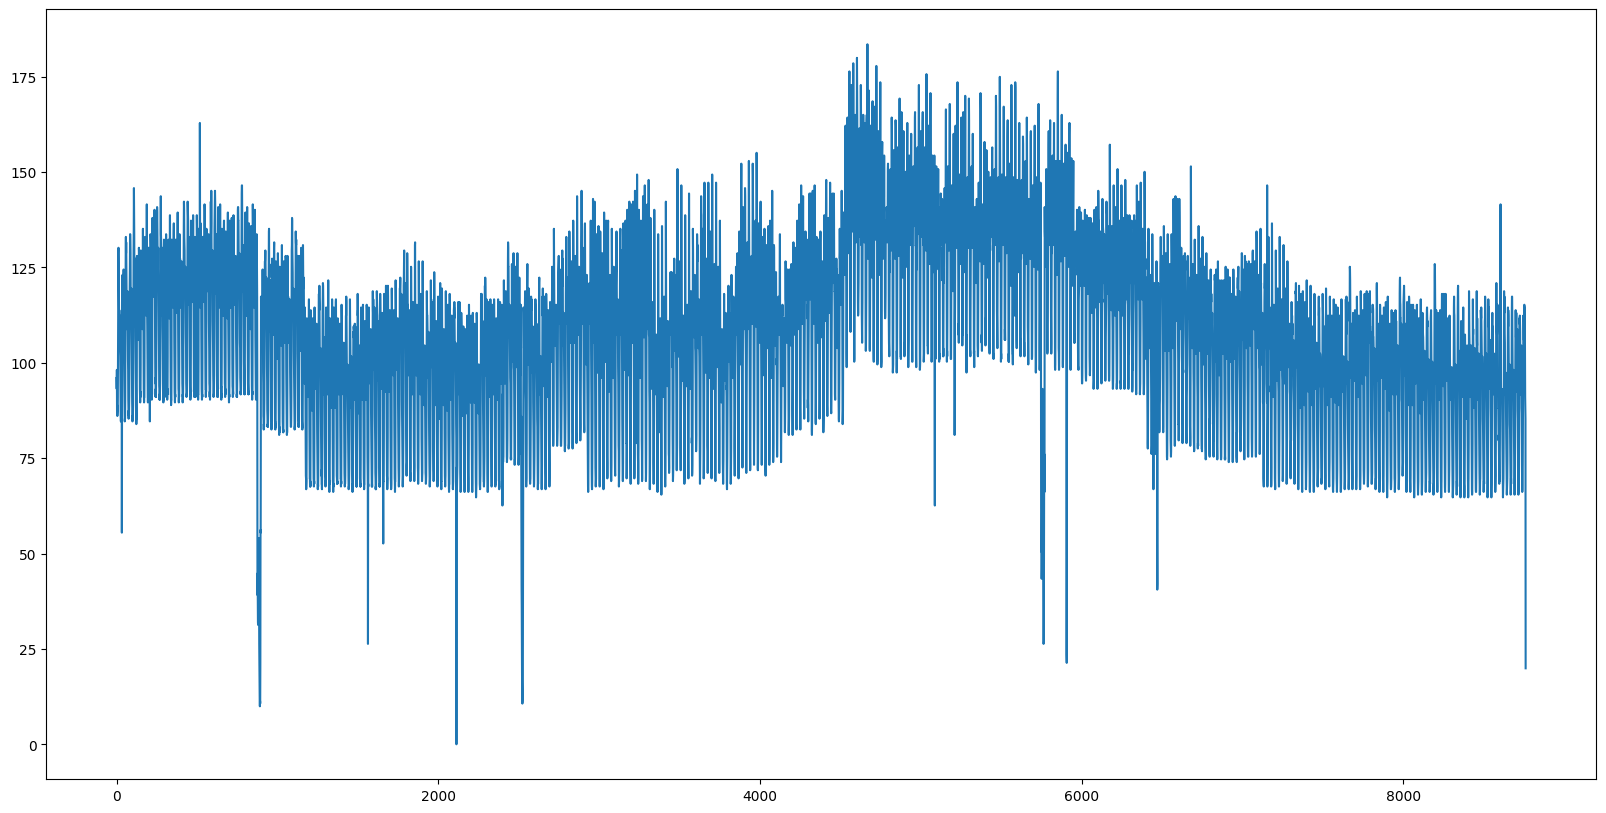

In [20]:
plt.figure(figsize=(20,10))
data['customer2'].plot()

<AxesSubplot: >

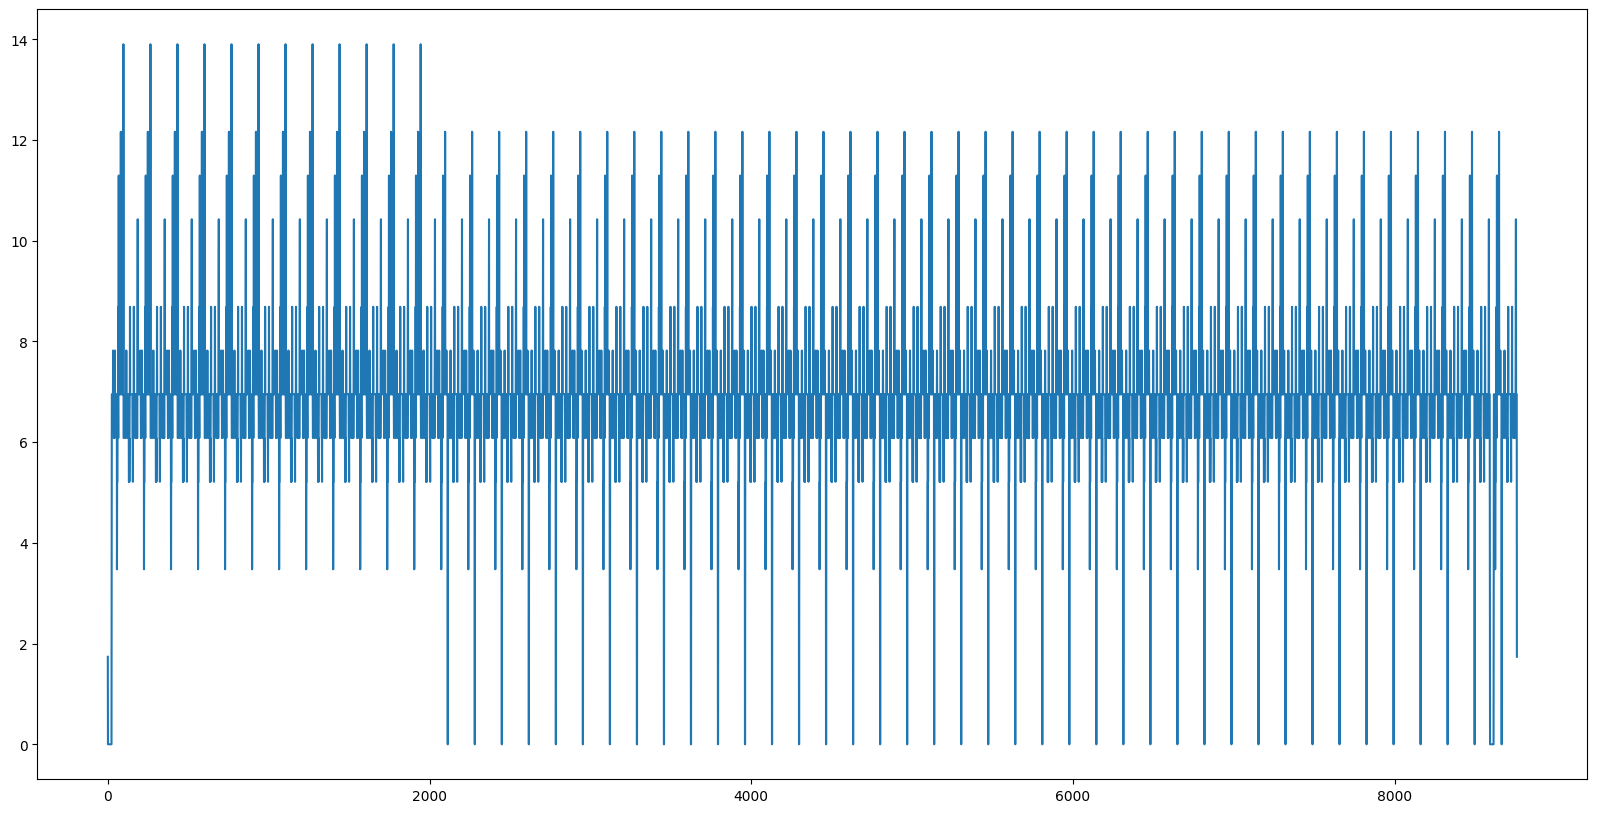

In [21]:
plt.figure(figsize=(20,10))
data['customer3'].plot()

<AxesSubplot: >

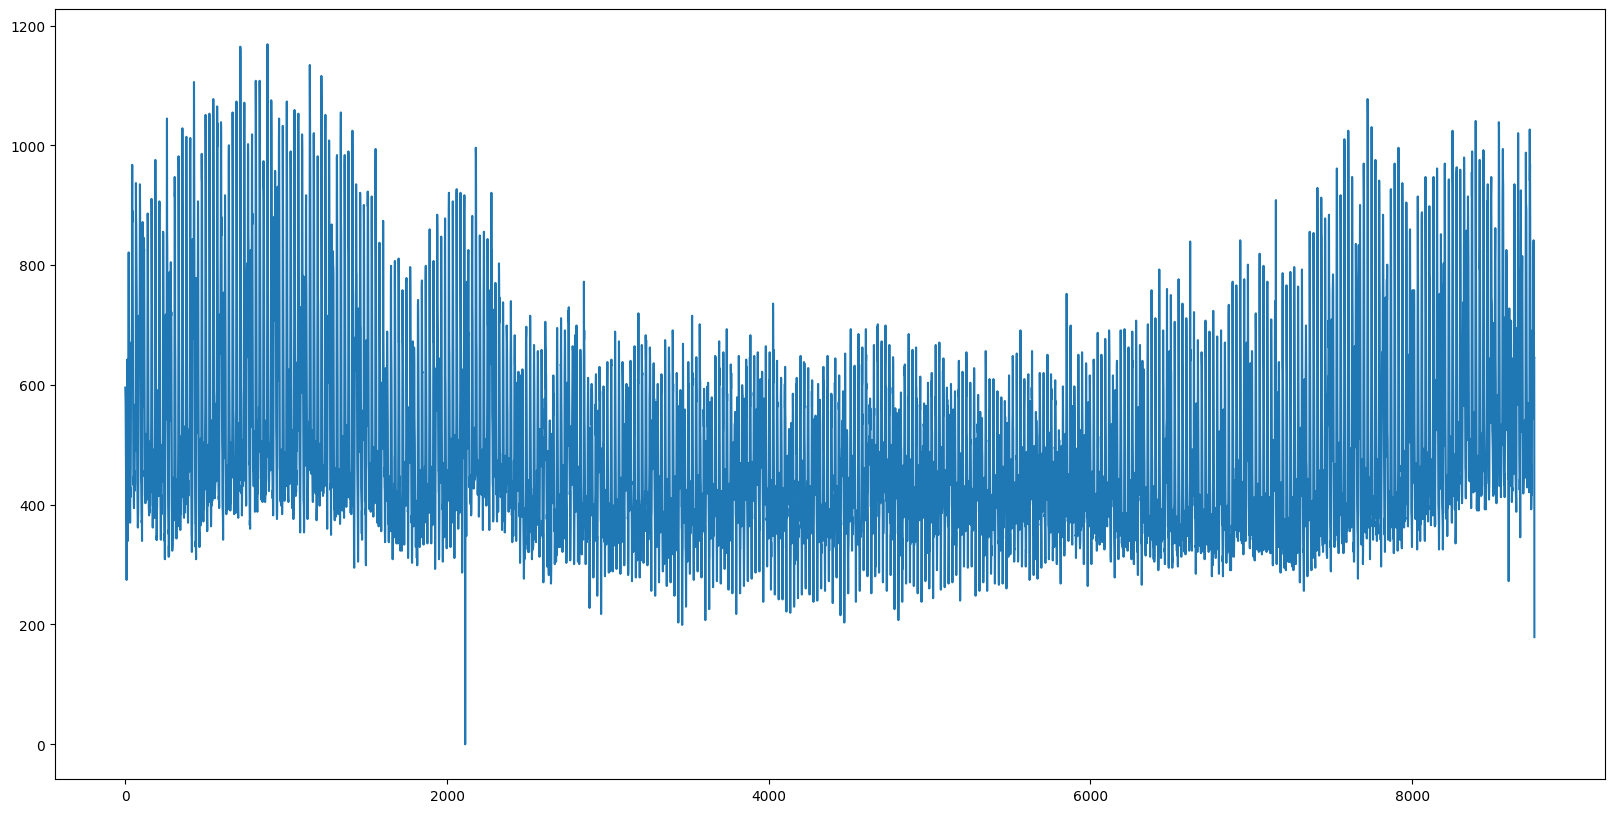

In [22]:
plt.figure(figsize=(20,10))
data['customer4'].plot()

<AxesSubplot: >

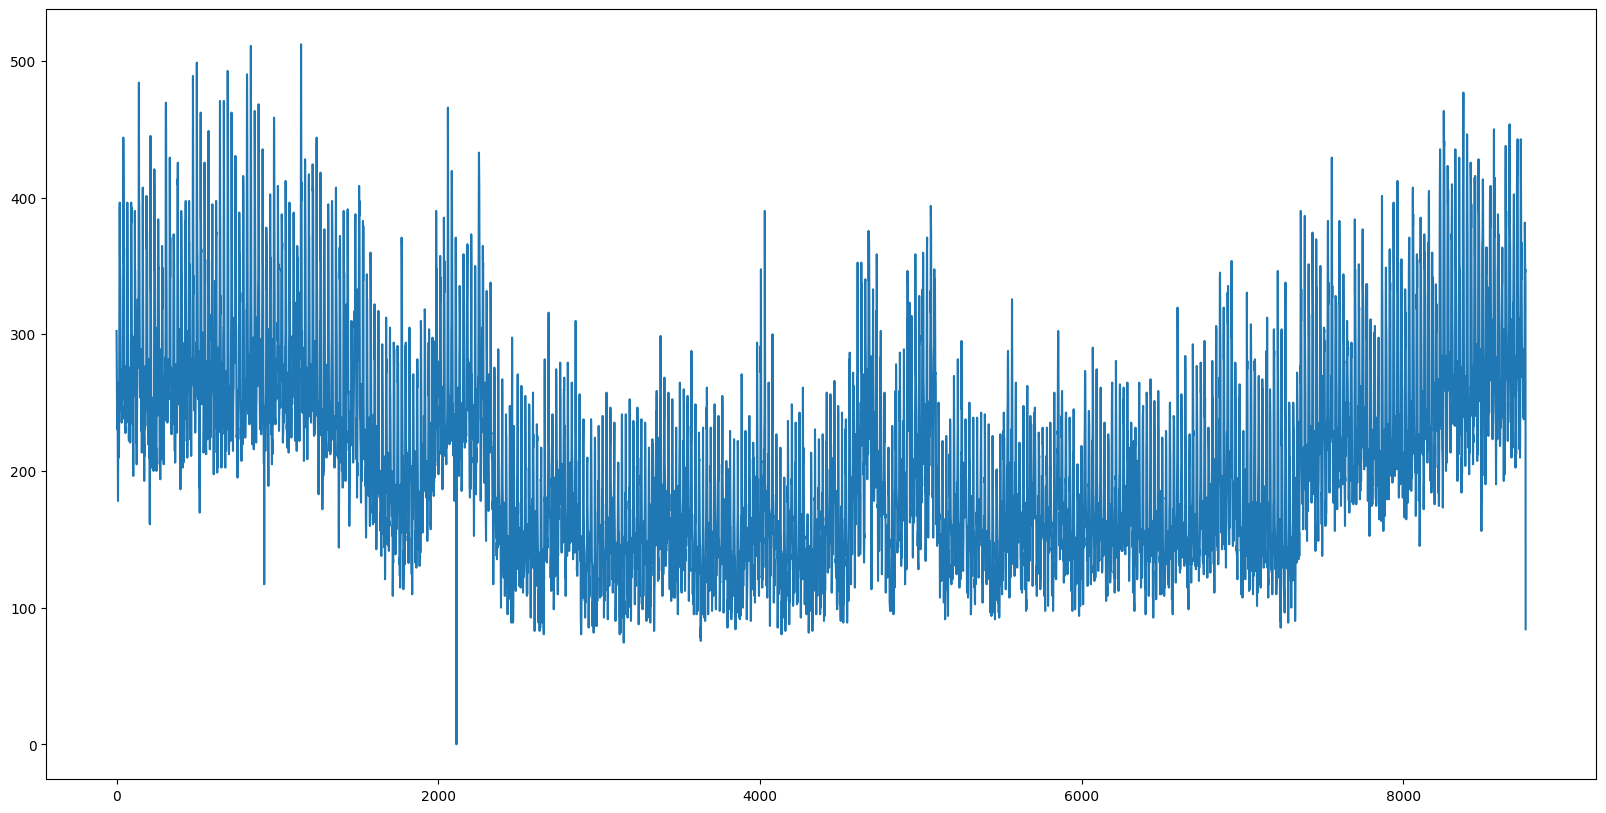

In [23]:
plt.figure(figsize=(20,10))
data['customer5'].plot()

<AxesSubplot: >

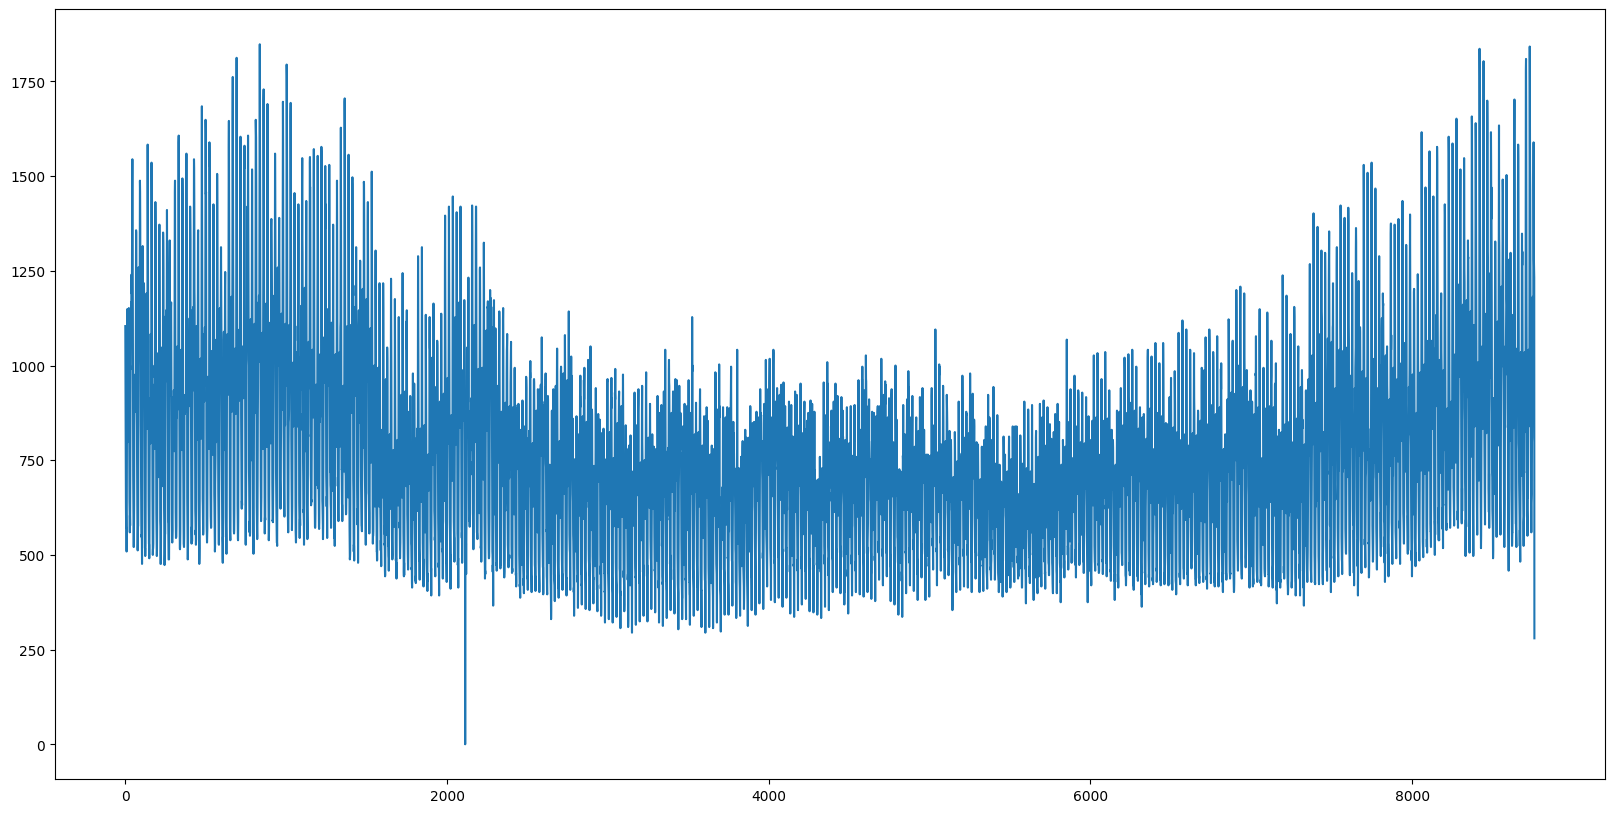

In [18]:
plt.figure(figsize=(20,10))
data['customer6'].plot()

<AxesSubplot: >

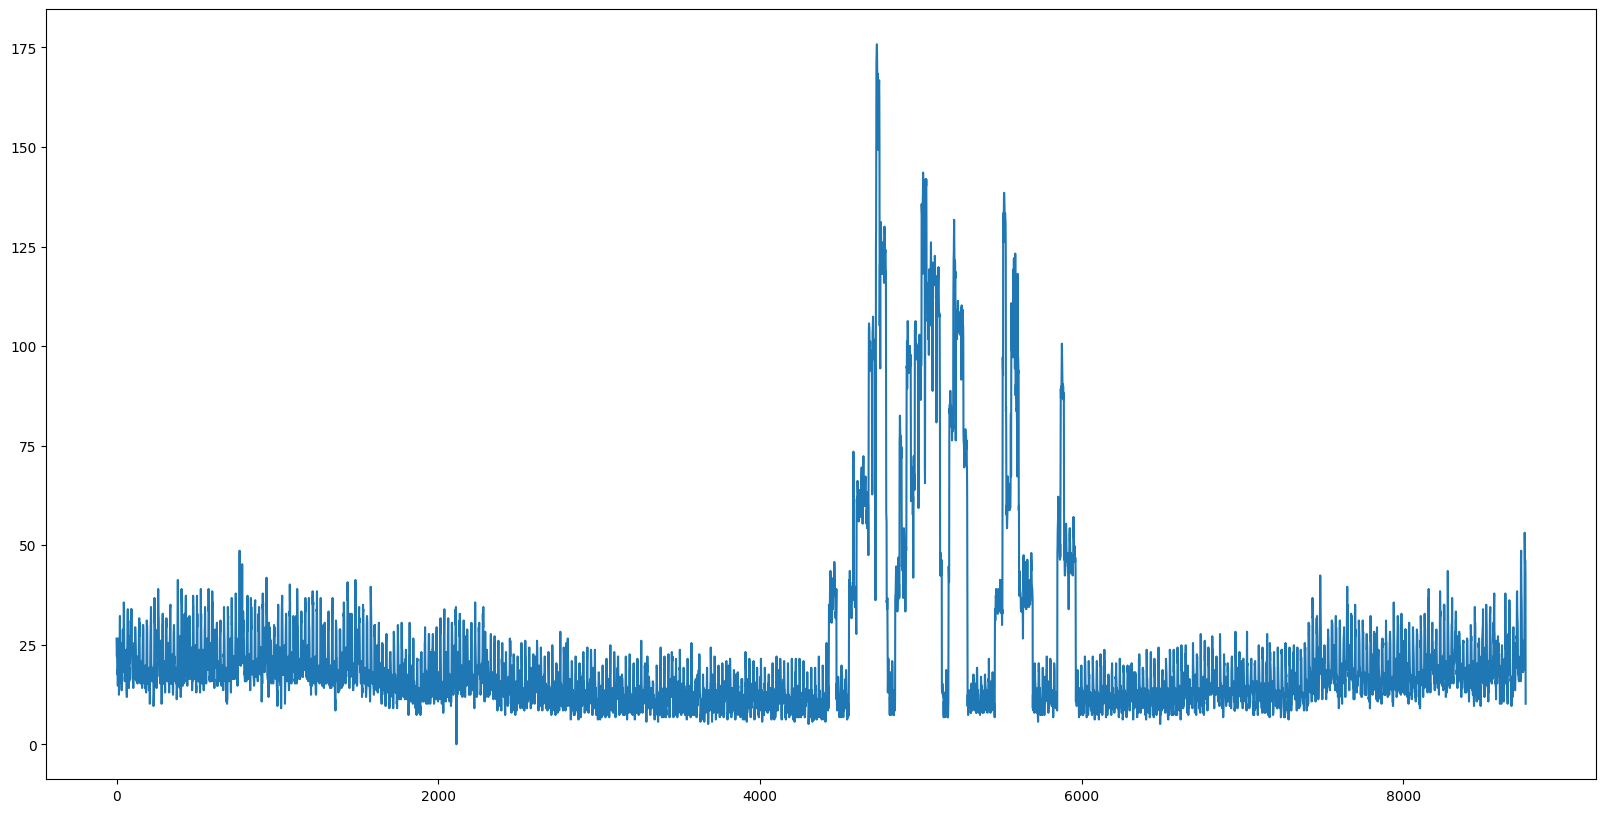

In [24]:
plt.figure(figsize=(20,10))
data['customer7'].plot()

<AxesSubplot: >

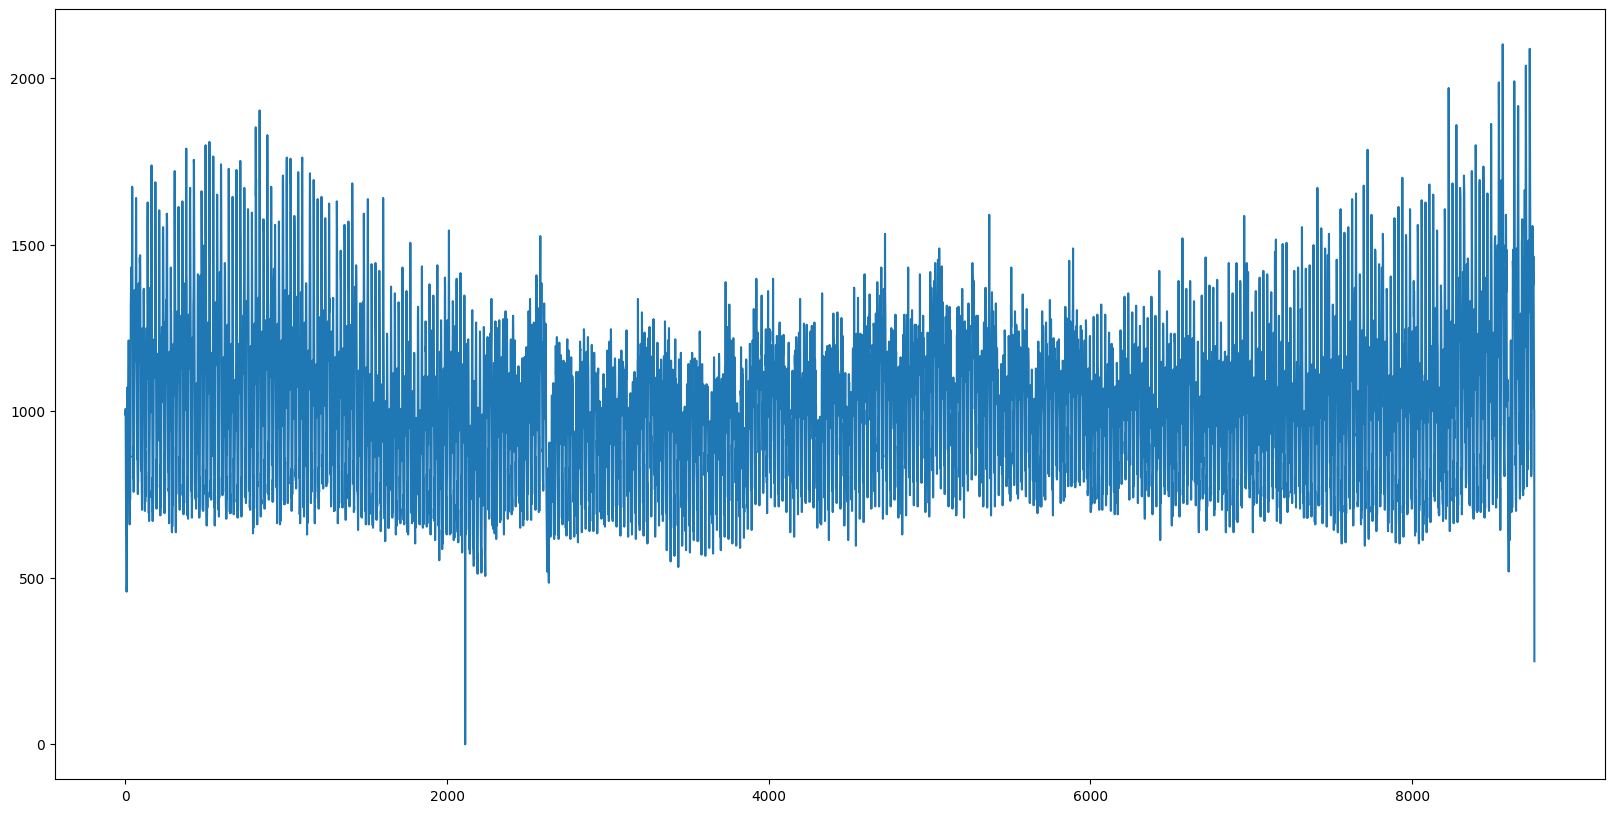

In [25]:
plt.figure(figsize=(20,10))
data['customer8'].plot()

<AxesSubplot: >

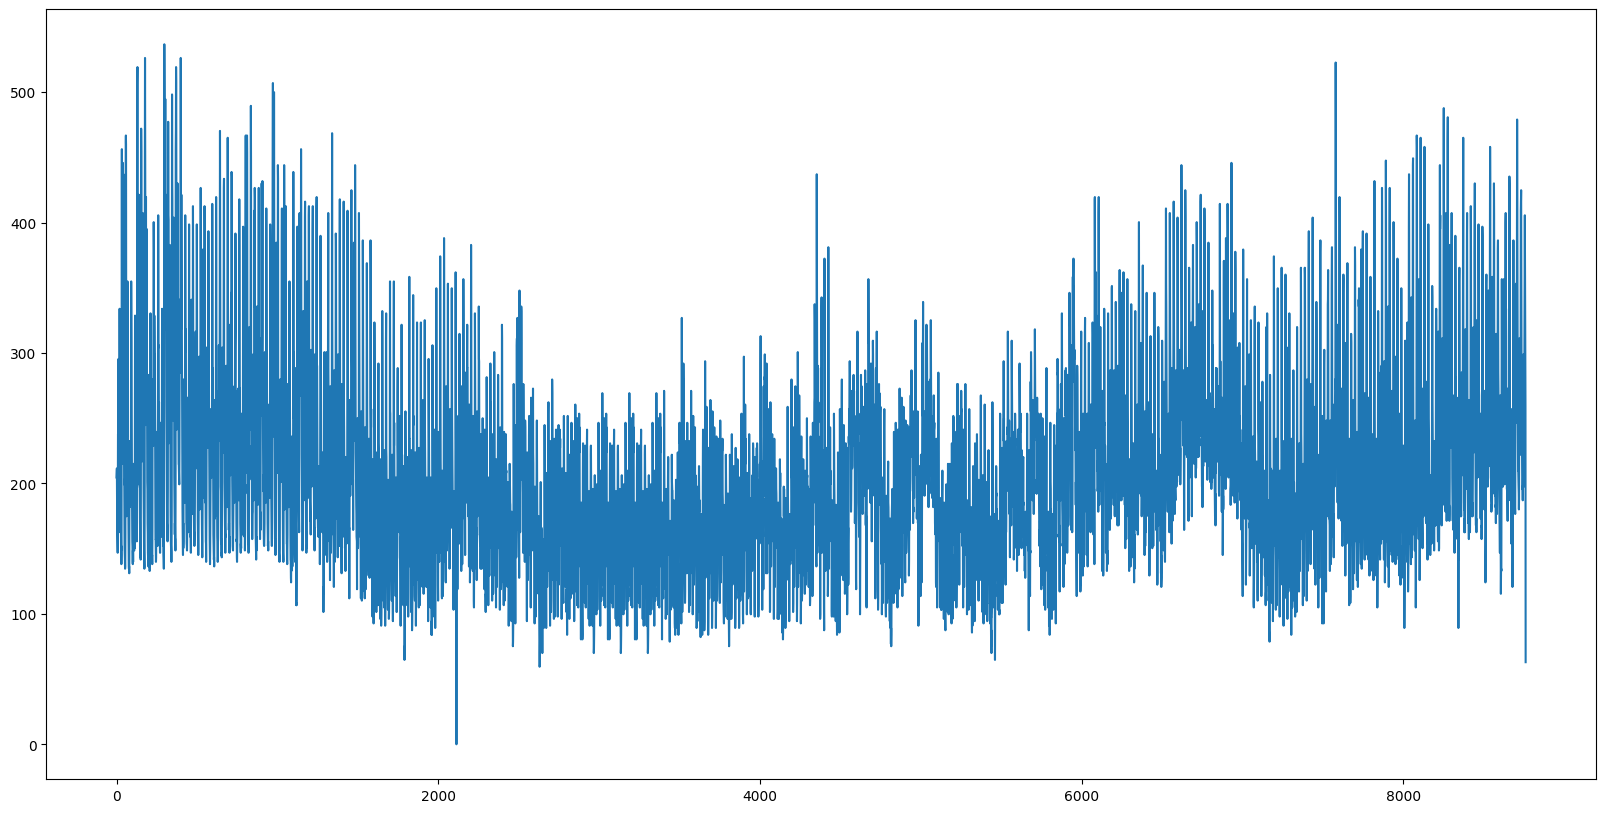

In [26]:
plt.figure(figsize=(20,10))
data['customer9'].plot()

<AxesSubplot: >

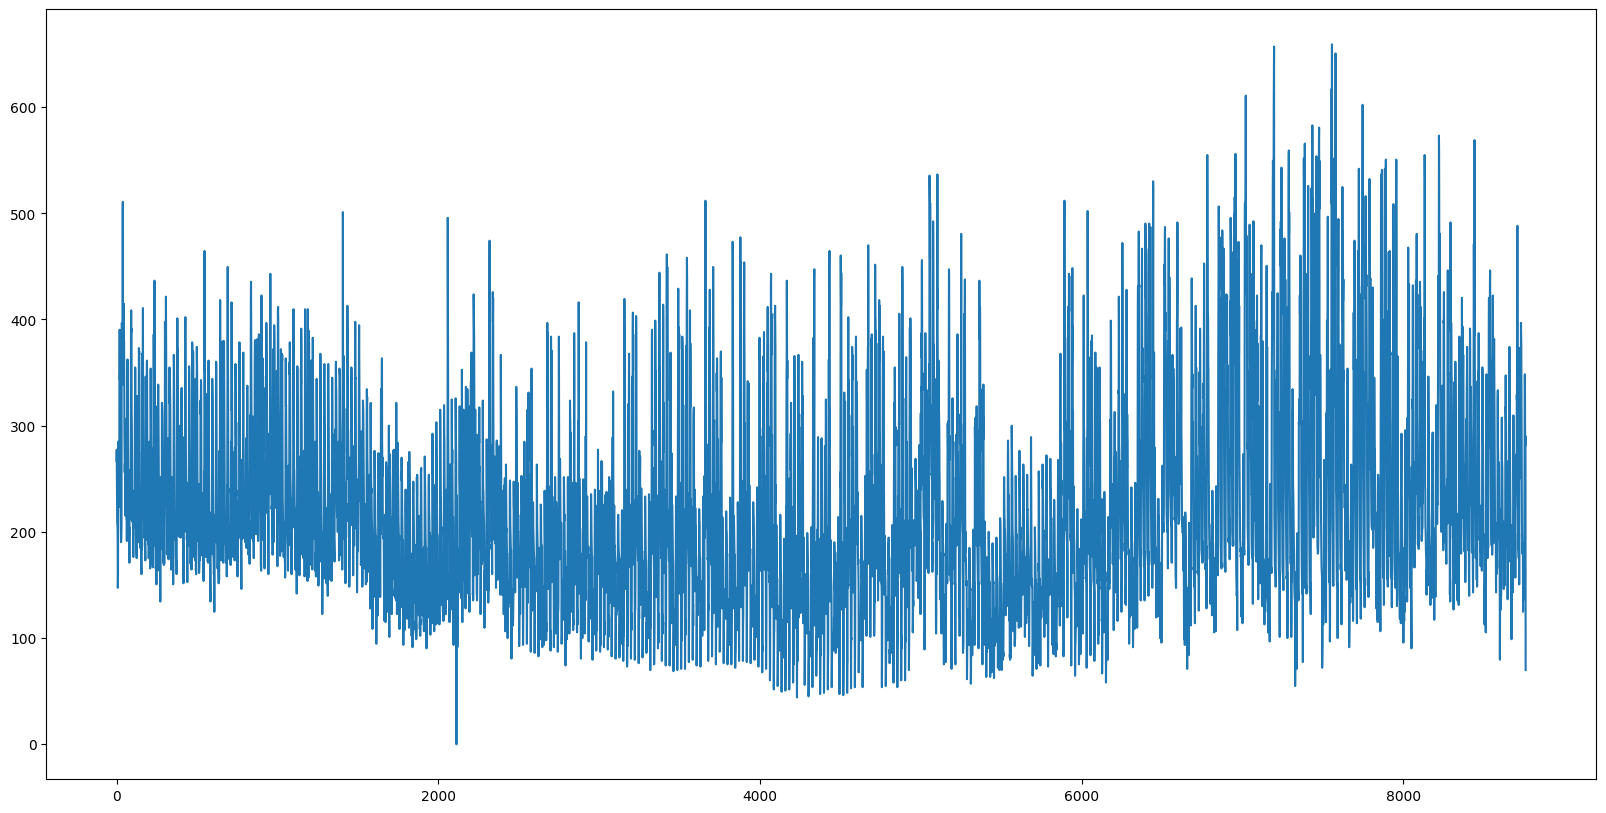

In [27]:
plt.figure(figsize=(20,10))
data['customer10'].plot()

In [28]:
from torch import FloatTensor as FloatTensor

In [81]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(len(x)-sequence_length):
        seq_list.append(np.transpose(x.iloc[i:i+sequence_length].values))
        target_list.append(np.transpose(x.iloc[i+sequence_length].values))

    return FloatTensor(seq_list).view(-1,x.shape[1],sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,x.shape[1],pred_len).to(device)

In [61]:
np.transpose(data.iloc[:sequence_length].values)

array([[  10.15228426,   11.4213198 ,   11.4213198 , ...,   11.4213198 ,
          11.4213198 ,   11.4213198 ],
       [  96.0170697 ,   93.17211949,   98.15078236, ...,  126.6002845 ,
         113.79800853,  108.81934566],
       [   1.73761946,    0.        ,    0.        , ...,    6.95047785,
           6.95047785,    6.95047785],
       ...,
       [ 989.8989899 , 1000.        , 1006.73400673, ..., 1515.15151515,
        1303.03030303, 1134.68013468],
       [ 204.54545455,  208.04195804,  211.53846154, ...,  335.66433566,
         300.6993007 ,  202.7972028 ],
       [ 266.66666667,  277.41935484,  249.46236559, ...,  313.97849462,
         331.1827957 ,  274.19354839]])

In [63]:
np.transpose(data.iloc[:sequence_length].values).shape

(10, 720)

In [62]:
data.shape[1]

10

In [37]:
split = 24*7 # 24시간 x 7로써 1주일을 테스트셋으로 만듦

In [38]:
seed = 42

In [39]:
device = torch.device("cuda:0")

In [113]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 1
        self.train_index = train_index
        self.model_list = nn.ModuleList()
        for i in range(10):
            tmp_model = nn.Linear(self.seq_len,self.pred_len)
            tmp_model.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            self.model_list.append(tmp_model)
    def forward(self,x):
        output = torch.zeros([x.shape[0],x.shape[1],self.pred_len])
        for i in range(x.shape[1]):
            output[:,i,:] = self.model_list[i](x[:,i,self.train_index])
        return output

# 3. Train-Validation set으로 쪼개기

In [87]:
data.iloc[:-split-val_num].tail(10)

,customer1,customer2,customer3,customer4,customer5,customer6,customer7,customer8,customer9,customer10
6831,11.421320,105.263158,6.081668,410.569106,157.317073,627.976190,16.958734,804.713805,183.566434,130.107527
6832,6.345178,102.418208,6.950478,357.723577,168.292683,538.690476,16.393443,841.750842,167.832168,107.526882
6833,3.807107,100.284495,6.950478,382.113821,170.731707,508.928571,12.436405,882.154882,223.776224,108.602151
6834,3.807107,105.974395,6.950478,376.016260,197.560976,571.428571,14.132278,956.228956,208.041958,106.451613
6835,6.345178,117.354196,7.819288,634.146341,289.024390,672.619048,13.566987,1127.946128,288.461538,167.741935
6836,7.614213,124.466572,6.950478,670.731707,306.097561,752.976190,18.089316,1178.451178,288.461538,243.010753
6837,7.614213,110.953058,6.950478,634.146341,303.658537,812.500000,19.785189,1161.616162,262.237762,236.559140
6838,7.614213,99.573257,6.950478,583.333333,302.439024,818.452381,22.046354,983.164983,288.461538,213.978495
6839,7.614213,91.749644,6.950478,445.121951,262.195122,642.857143,19.785189,872.053872,255.244755,186.021505
6840,7.614213,87.482219,6.950478,402.439024,210.975610,517.857143,19.219898,757.575758,250.000000,179.569892


* 8761개 중 일주일치 데이터인 168개의 데이터를 Test Set
* 8761 중 0.2의 비율인 1752개는 validation set
* 8761개 중 0.8의 비율인 7009개는 train set

In [65]:
val_num = 1752

In [84]:
train = data.iloc[:-split-val_num]
val = data.iloc[-split-val_num:-split]
x_train,y_train = seq_data(train, sequence_length = sequence_length, pred_len = pred_len)
x_val,y_val = seq_data(val, sequence_length = sequence_length, pred_len = pred_len)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

In [89]:
x_train.shape

torch.Size([6121, 10, 720])

In [74]:
data.iloc[:-split-val_num].tail(10)

,customer1,customer2,customer3,customer4,customer5,customer6,customer7,customer8,customer9,customer10
6831,11.421320,105.263158,6.081668,410.569106,157.317073,627.976190,16.958734,804.713805,183.566434,130.107527
6832,6.345178,102.418208,6.950478,357.723577,168.292683,538.690476,16.393443,841.750842,167.832168,107.526882
6833,3.807107,100.284495,6.950478,382.113821,170.731707,508.928571,12.436405,882.154882,223.776224,108.602151
6834,3.807107,105.974395,6.950478,376.016260,197.560976,571.428571,14.132278,956.228956,208.041958,106.451613
6835,6.345178,117.354196,7.819288,634.146341,289.024390,672.619048,13.566987,1127.946128,288.461538,167.741935
6836,7.614213,124.466572,6.950478,670.731707,306.097561,752.976190,18.089316,1178.451178,288.461538,243.010753
6837,7.614213,110.953058,6.950478,634.146341,303.658537,812.500000,19.785189,1161.616162,262.237762,236.559140
6838,7.614213,99.573257,6.950478,583.333333,302.439024,818.452381,22.046354,983.164983,288.461538,213.978495
6839,7.614213,91.749644,6.950478,445.121951,262.195122,642.857143,19.785189,872.053872,255.244755,186.021505
6840,7.614213,87.482219,6.950478,402.439024,210.975610,517.857143,19.219898,757.575758,250.000000,179.569892


In [94]:
x_train[:,0,:]

tensor([[10.1523, 11.4213, 11.4213,  ..., 11.4213, 11.4213, 11.4213],
        [11.4213, 11.4213, 11.4213,  ..., 11.4213, 11.4213, 11.4213],
        [11.4213, 11.4213, 10.1523,  ..., 11.4213, 11.4213, 10.1523],
        ...,
        [65.9898, 65.9898, 67.2589,  ...,  6.3452,  7.6142,  7.6142],
        [65.9898, 67.2589, 65.9898,  ...,  7.6142,  7.6142,  7.6142],
        [67.2589, 65.9898, 65.9898,  ...,  7.6142,  7.6142,  7.6142]],
       device='cuda:0')

In [92]:
x_train[:64,0,:].shape

torch.Size([64, 720])

In [90]:
x_train

tensor([[[  10.1523,   11.4213,   11.4213,  ...,   11.4213,   11.4213,
            11.4213],
         [  96.0171,   93.1721,   98.1508,  ...,  126.6003,  113.7980,
           108.8193],
         [   1.7376,    0.0000,    0.0000,  ...,    6.9505,    6.9505,
             6.9505],
         ...,
         [ 989.8990, 1000.0000, 1006.7340,  ..., 1515.1515, 1303.0303,
          1134.6802],
         [ 204.5455,  208.0420,  211.5385,  ...,  335.6643,  300.6993,
           202.7972],
         [ 266.6667,  277.4193,  249.4624,  ...,  313.9785,  331.1828,
           274.1935]],

        [[  11.4213,   11.4213,   11.4213,  ...,   11.4213,   11.4213,
            11.4213],
         [  93.1721,   98.1508,   87.4822,  ...,  113.7980,  108.8193,
            99.5733],
         [   0.0000,    0.0000,    0.0000,  ...,    6.9505,    6.9505,
             6.9505],
         ...,
         [1000.0000, 1006.7340,  831.6498,  ..., 1303.0303, 1134.6802,
           875.4209],
         [ 208.0420,  211.5385,  187.062

In [17]:
next(iter(validation))[0].size()

torch.Size([64, 1, 720])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [114]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(sequence_length)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = SMAPE()
num_epochs = 100
n= len(training)

### 기본 모델 training

In [115]:
import copy

In [124]:
labels.shape

torch.Size([64, 10, 1])

In [123]:
outputs.shape

torch.Size([640, 1])

In [125]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=200
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        print(labels)
        outputs = model(inputs)
        outputs = outputs.to(device)
        labels = labels.to(device)
        
        # defining loss
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

tensor([[[  11.4213],
         [  99.5733],
         [   6.9505],
         [ 577.2358],
         [ 250.0000],
         [ 866.0714],
         [  23.7422],
         [ 875.4209],
         [ 190.5594],
         [ 227.9570]],

        [[  10.1523],
         [  93.8834],
         [   6.9505],
         [ 475.6097],
         [ 241.4634],
         [ 785.7143],
         [  19.2199],
         [ 784.5118],
         [ 167.8322],
         [ 211.8280]],

        [[  11.4213],
         [  93.1721],
         [   6.9505],
         [ 443.0894],
         [ 235.3659],
         [ 699.4048],
         [  16.3934],
         [ 683.5017],
         [ 152.0979],
         [ 191.3978]],

        [[  11.4213],
         [  91.0384],
         [   6.9505],
         [ 418.6992],
         [ 221.9512],
         [ 639.8810],
         [  17.5240],
         [ 801.3468],
         [ 150.3497],
         [ 179.5699]],

        [[  12.6904],
         [  92.4609],
         [   6.9505],
         [ 432.9268],
         [ 214.6341],
  

RuntimeError: The size of tensor a (64) must match the size of tensor b (10) at non-singleton dimension 1

### validation set에 대해서 attribution 구하기

In [21]:
n = len(validation)
n

43

In [22]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((1,sequence_length))
for val in validation:
    temp_n = val[0].size(0)
    temp = nt_ig.attribute(val[0]).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음
    nt_ig_attr_score = nt_ig_attr_score.to(device)+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [23]:
len(nt_ig_attr_score)

720

<AxesSubplot: >

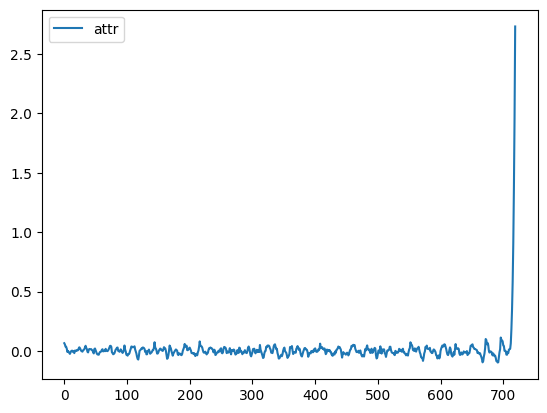

In [24]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

### &rightarrow; 최근데이터가 매우강조 되는것을 확인할 수 있다.

#### scaling

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
attr_df

,attr
0,0.377648
1,0.307238
2,0.176870
3,0.170535
4,0.056070
...,...
715,3.953783
716,6.233129
717,9.481812
718,13.467816


#### train_index구하기

In [26]:
index_list = []

for hyper_parameter in np.arange(0.01,1.01,0.01):
    append_idx = list(attr_df[(attr_df['attr']>hyper_parameter) | (attr_df['attr']<-hyper_parameter)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

100

In [27]:
len_list=[]
for i in range(100):
    len_list.append(len(index_list[i]))


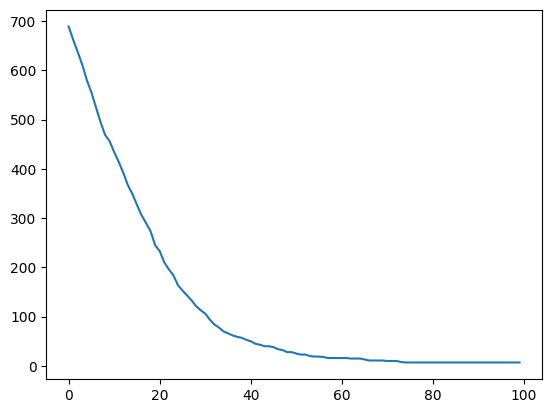

In [28]:
plt.plot(np.arange(100),len_list) # 포함되는 time_index의 갯수

In [29]:
for val_x,val_y in validation:
    print(val_x,val_y)

tensor([[[ 0.0000, -0.6330, -0.6330,  ...,  4.9240,  5.1350,  4.6430]],

        [[-0.6330, -0.6330, -0.7030,  ...,  5.1350,  4.6430,  4.5020]],

        [[-0.6330, -0.7030, -1.2660,  ...,  4.6430,  4.5020,  4.5730]],

        ...,

        [[ 1.6880,  1.6180,  1.9700,  ...,  2.7440,  3.0250,  3.0250]],

        [[ 1.6180,  1.9700,  1.7590,  ...,  3.0250,  3.0250,  3.8690]],

        [[ 1.9700,  1.7590,  1.4770,  ...,  3.0250,  3.8690,  4.5020]]],
       device='cuda:0') tensor([[[4.5020]],

        [[4.5730]],

        [[4.6430]],

        [[4.5020]],

        [[4.1500]],

        [[4.5730]],

        [[4.7130]],

        [[5.3460]],

        [[6.1910]],

        [[6.3310]],

        [[5.9790]],

        [[6.7530]],

        [[7.8090]],

        [[8.1600]],

        [[8.2310]],

        [[8.3710]],

        [[8.1600]],

        [[7.3160]],

        [[6.4020]],

        [[6.1200]],

        [[5.7680]],

        [[5.8390]],

        [[5.6980]],

        [[5.4170]],

        [[5.7680]],


       device='cuda:0') tensor([[[7.1750]],

        [[7.0350]],

        [[6.8940]],

        [[7.3860]],

        [[7.3160]],

        [[7.1050]],

        [[7.1050]],

        [[7.1050]],

        [[6.9640]],

        [[6.7530]],

        [[6.8240]],

        [[6.8240]],

        [[6.7530]],

        [[6.8240]],

        [[7.1050]],

        [[7.2460]],

        [[7.3860]],

        [[7.1750]],

        [[6.9640]],

        [[6.8240]],

        [[6.6830]],

        [[6.3310]],

        [[6.5420]],

        [[4.3620]],

        [[5.5570]],

        [[5.6280]],

        [[5.9790]],

        [[5.6980]],

        [[5.9090]],

        [[5.7680]],

        [[5.6980]],

        [[5.4170]],

        [[5.7680]],

        [[5.6280]],

        [[5.6980]],

        [[6.0500]],

        [[5.9090]],

        [[5.9790]],

        [[6.0500]],

        [[6.4720]],

        [[6.4020]],

        [[6.4020]],

        [[6.7530]],

        [[7.1050]],

        [[7.1750]],

        [[7.3160]],

        [[

In [26]:
val_x

tensor([[[2793782., 2791816., 2791590.,  ..., 2805477., 2807247., 2804741.]],

        [[2791816., 2791590., 2792746.,  ..., 2807247., 2804741., 2805965.]],

        [[2791590., 2792746., 2791385.,  ..., 2804741., 2805965., 2806690.]],

        ...,

        [[2790771., 2791033., 2792336.,  ..., 2805795., 2804113., 2803545.]],

        [[2791033., 2792336., 2792659.,  ..., 2804113., 2803545., 2805464.]],

        [[2792336., 2792659., 2791127.,  ..., 2803545., 2805464., 2805264.]]],
       device='cuda:0')

In [30]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
out_list = []
num_epochs = 100
criterion = SMAPE()
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=200
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = criterion(pred,val_target).item()*100
    out_list.append(result)
    


changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:10.420931485004543
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
13번째 모델 Training 완료 마지막 Epoch loss:9.404328554505256
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
23번째 모델 Training 완료 마지막 Epoch loss:8.891236638514007
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
24번째 모델 Training 완료 마지막 Epoch loss:9.222802

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
33번째 모델 Training 완료 마지막 Epoch loss:8.886777081685821
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
43번째 모델 Training 완료 마지막 Epoch loss:8.880951977902797
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
52번째 모델 Training 완료 마지막 Epoch loss:8.882191690003
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
change

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
62번째 모델 Training 완료 마지막 Epoch loss:8.764511128751243
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
71번째 모델 Training 완료 마지막 Epoch loss:8.960515512380658
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
72번째 모델 Training 완료 마지막 Epoch loss:8.960515512380658
changed
changed
changed
changed
changed
changed
change

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
81번째 모델 Training 완료 마지막 Epoch loss:8.850407947490856
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
91번째 모델 Training 완료 마지막 Epoch loss:8.850407947490856
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

In [31]:
val_y # 다음 예측 타겟값

tensor([[[ 9.2150]],

        [[ 8.8640]],

        [[ 9.0750]],

        [[ 9.0040]],

        [[ 9.2150]],

        [[ 9.2860]],

        [[ 9.1450]],

        [[ 9.7780]],

        [[ 9.9890]],

        [[10.0600]],

        [[10.8330]],

        [[11.1850]],

        [[11.9590]],

        [[13.0850]],

        [[11.9590]],

        [[12.0290]],

        [[12.0290]],

        [[11.8180]],

        [[10.6220]],

        [[10.2000]],

        [[10.1300]],

        [[10.2710]],

        [[ 9.7780]],

        [[ 9.2150]],

        [[ 9.2150]],

        [[ 9.0750]],

        [[ 9.0040]],

        [[ 9.1450]],

        [[ 9.6380]],

        [[ 9.4970]],

        [[ 9.0750]],

        [[ 9.3560]],

        [[ 9.7780]],

        [[ 9.8490]],

        [[10.1300]],

        [[ 9.7780]],

        [[ 5.5570]],

        [[ 5.6280]],

        [[ 4.6430]],

        [[ 5.2760]],

        [[ 6.6830]]], device='cuda:0')

In [32]:
val_x # 예측 하는 값

tensor([[[8.2310, 8.5120, 7.8090,  ..., 9.5670, 9.2860, 9.2150]],

        [[8.5120, 7.8090, 7.7380,  ..., 9.2860, 9.2150, 9.2150]],

        [[7.8090, 7.7380, 7.7380,  ..., 9.2150, 9.2150, 8.8640]],

        ...,

        [[6.5420, 4.3620, 5.5570,  ..., 9.7780, 5.5570, 5.6280]],

        [[4.3620, 5.5570, 5.6280,  ..., 5.5570, 5.6280, 4.6430]],

        [[5.5570, 5.6280, 5.9790,  ..., 5.6280, 4.6430, 5.2760]]],
       device='cuda:0')

In [33]:
result/68

0.1297820797737907

In [34]:
val_x.size()

torch.Size([41, 1, 720])

In [36]:
out_df = pd.DataFrame({"out":out_list})

 ## Out Result
 - 계속해서 낮아지는것을 확인할 수 있다.

<AxesSubplot: >

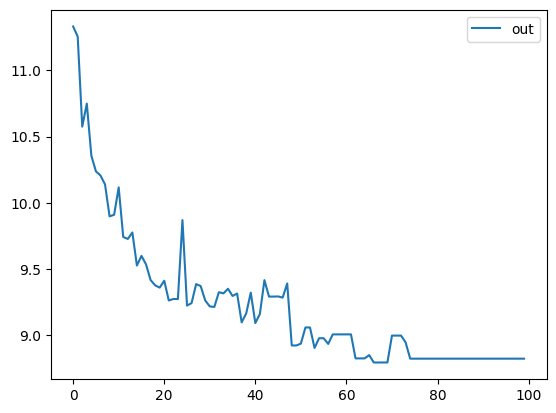

In [37]:
out_df.plot()

In [38]:
out_df.min()

out    8.796393
dtype: float64

In [46]:
same_out_list = []
for i in range(99):
    if out_df.iloc[i].item()==out_df.iloc[i+1].item():
        same_out_list.append(i)

In [44]:
same_length_list = []
for i in range(99):
    if len_list[i]==len_list[i+1]:
        same_length_list.append(i)

In [48]:
same_out_list == same_length_list

True

In [49]:
same_length_list

[43,
 48,
 51,
 54,
 57,
 58,
 59,
 60,
 62,
 63,
 66,
 67,
 68,
 70,
 71,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98]

# minimum of out

In [39]:
out_df[out_df['out']==out_df['out'].min()]

,out
66,8.796393
67,8.796393
68,8.796393
69,8.796393


In [40]:
attr_df.describe()

,attr
count,7.200000e+02
mean,2.467162e-17
std,1.000695e+00
min,-7.441758e-01
25%,-2.052670e-01
50%,-7.296442e-02
75%,5.069650e-02
max,1.881449e+01
